Final A_tilde:
 [[ 0.99832256  0.39958856]
 [ 0.00862759 -0.98756391]]
Final B_tilde:
 [[0.19898521]
 [0.501387  ]]


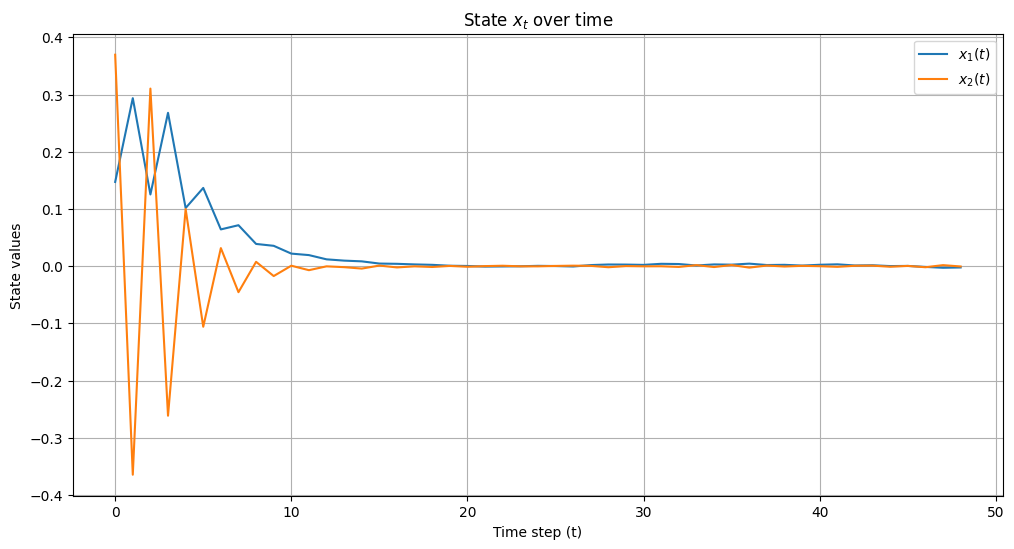

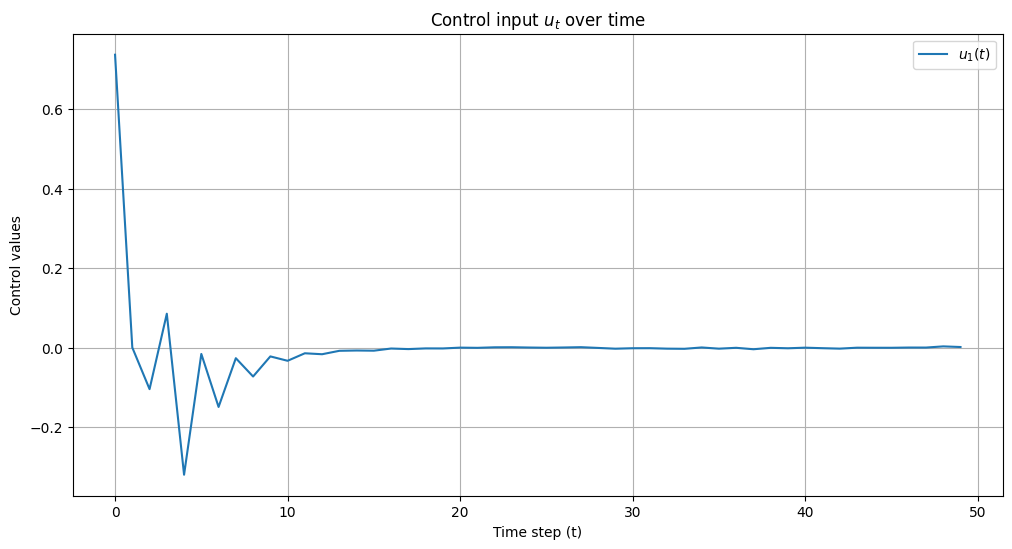

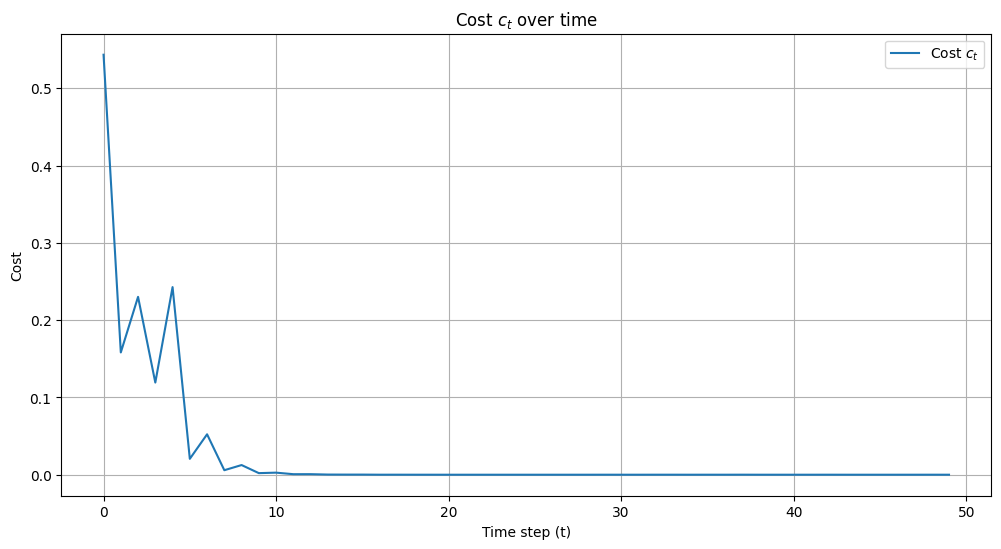

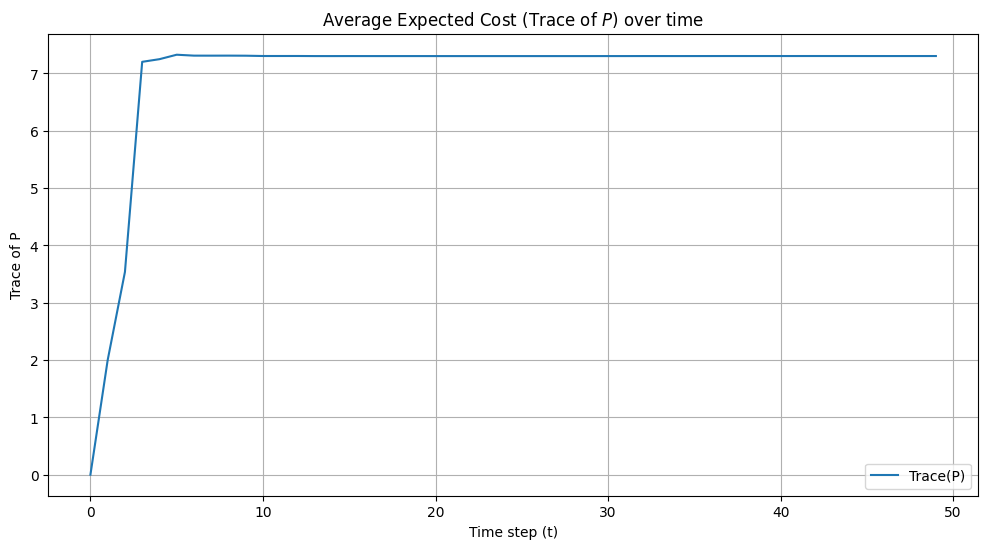

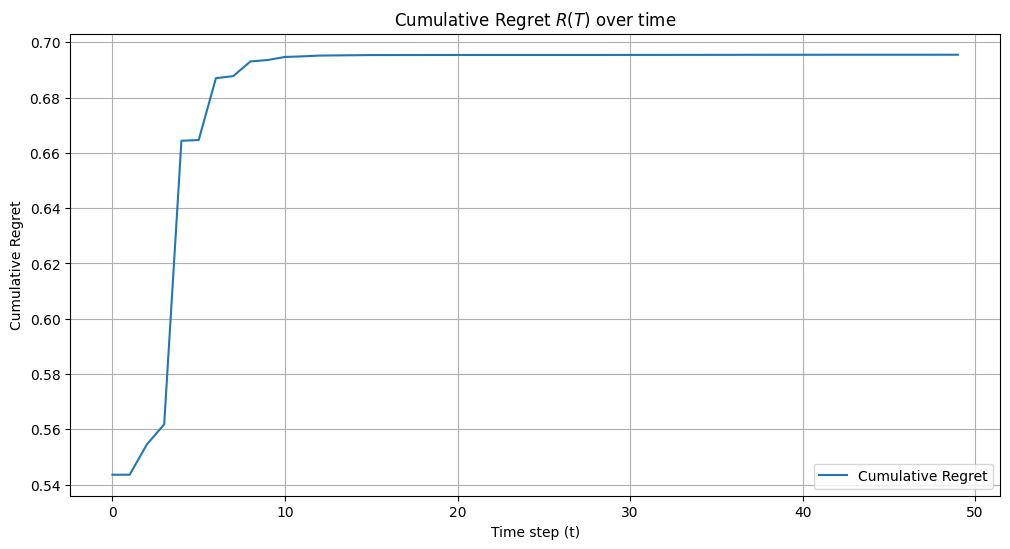

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from control import dare
from scipy.optimize import minimize

# Adaptive LQ Controller class definition
class LeastSquareApproach:
    def __init__(self, A_star, B_star, Q, R, T, lambda_reg, n, d):
        """
        Initialize the controller with given system parameters.
        """
        self.A_star = A_star  # True system dynamics (unknown to the controller)
        self.B_star = B_star  # True control matrix (unknown to the controller)
        self.Q = Q            # State cost matrix
        self.R = R            # Control cost matrix
        self.T = T            # Time steps
        self.lambda_reg = lambda_reg  # Regularization constant
        self.n = n            # State dimension
        self.d = d            # Control dimension
        
        # Initialize empty lists to store data
        self.dataset_z_t = []
        self.dataset_x_t1 = []
        self.u_t_values = []
        self.cost_values = []
        self.average_expected_cost = []
        self.regret_values = []
        
        # Initial parameters
        self.V_t = lambda_reg * np.eye(n + d)  # Initial regularized design matrix
        self.Theta_hat = np.zeros((n + d, n))  # Initial parameter estimate
        self.P = np.zeros((n, n))              # Riccati matrix (for cost computation)
        self.cumulative_cost = 0               # To accumulate the cost over time
        self.cumulative_optimal_cost = 0       # To accumulate optimal cost over time
    
    def cost(self, x_t, u_t):
        """
        Compute the quadratic cost for given state x_t and control u_t.
        """
        return x_t.T @ self.Q @ x_t + u_t.T @ self.R @ u_t
    
    def simulate_system(self, x_t, u_t, noise):
        """
        Simulate the system for the next state given the current state x_t and control u_t.
        """
        return self.A_star @ x_t + self.B_star @ u_t + noise
    
    def regularized_least_squares(self, Z, X):
        """
        Regularized least squares estimation.
        Z: Input data (stacked states and control inputs)
        X: Output data (next states)
        """
        V_t = Z.T @ Z + self.lambda_reg * np.eye(self.n + self.d)  # Add regularization term
        theta_hat = np.linalg.pinv(V_t) @ Z.T @ X  # Solve for theta_hat using least squares
        return theta_hat
    

    def cost_function(self, Theta, Z, X):
        """
        Regularized least squares cost function for parameter estimation.
        """
        residual = X - Z @ Theta
        regularization = self.lambda_reg * np.sum(Theta ** 2)
        return np.sum(residual ** 2) + regularization
    
    def update_controller(self, x_t):
        """
        Update the controller parameters using least squares estimation and Riccati equation.
        """
        if len(self.dataset_z_t) > 0:
            Z = np.vstack(self.dataset_z_t)  # (T, n+d)
            self.X = np.vstack(self.dataset_x_t1)  # (T, n)
            self.Theta_tilde = self.regularized_least_squares(Z, self.X)
        
            # Extract A_tilde and B_tilde from Theta_hat
            A_tilde = self.Theta_tilde[:self.n, :].T
            B_tilde = self.Theta_tilde[self.n:, :].T
            
            # Solve Riccati equation for the estimated parameters
            self.P, _, _ = dare(A_tilde, B_tilde, self.Q, self.R)
            
            # Compute control gain K_tilde
            K_tilde = -np.linalg.inv(self.R + B_tilde.T @ self.P @ B_tilde) @ B_tilde.T @ self.P @ A_tilde
            return K_tilde, A_tilde, B_tilde
        return None, None, None
    
    def run(self):
        """
        Run the adaptive control simulation over T time steps.
        """
        x_t = np.zeros((self.n, 1))  # Initial state
        T_explore = 0            # Number of initial exploration steps
        explore_noise_scale = 1      # Noise scale for exploration
        
        for t in range(self.T):
            if t < T_explore:
                # Exploration phase: use random control inputs
                u_t = explore_noise_scale * np.random.randn(self.d, 1)
            else:
                K_tilde, A_tilde, B_tilde = self.update_controller(x_t)
                if K_tilde is not None:
                    u_t = K_tilde @ x_t  # Control law from adaptive parameters
                else:
                    u_t = explore_noise_scale * np.random.randn(self.d, 1)  # Fallback if controller not updated
            
            # Simulate system and observe new state
            noise = 0.001 * np.random.randn(self.n, 1)
            x_t1 = self.simulate_system(x_t, u_t, noise)
            
            # Compute cost and store values
            c_t = self.cost(x_t, u_t)
            self.cost_values.append(c_t)
            self.cumulative_cost += c_t
            
            # Calculate optimal cost (assuming full knowledge of A_star and B_star)
            P_opt, _, _ = dare(self.A_star, self.B_star, self.Q, self.R)
            J_star =  x_t.T @ self.Q @ x_t  # Optimal cost for LQ problem
            self.cumulative_optimal_cost += J_star
            
            # Compute cumulative regret at each time step
            cumulative_regret = self.cumulative_cost - self.cumulative_optimal_cost
            self.regret_values.append(cumulative_regret)  # Store cumulative regret
            
            # Record data for least-squares updates
            z_t = np.vstack([x_t, u_t])  # Combine state and control for least squares
            self.dataset_z_t.append(z_t.T)
            self.dataset_x_t1.append(x_t1.T)
            self.u_t_values.append(u_t.T)
            
            # Update the design matrix V_t
            self.V_t += z_t @ z_t.T
            
            # Move to next state
            x_t = x_t1
            
            # Store the trace of P (average expected cost)
            self.average_expected_cost.append(np.trace(self.P))
        
        # Output final A_tilde and B_tilde
        print("Final A_tilde:\n", A_tilde)
        print("Final B_tilde:\n", B_tilde)


    def plot_results(self):
        """
        Plot the results of the simulation.
        """
        time_steps = np.arange(self.T)
        time_steps1 = np.arange(self.T-1)
        
        # Plot state trajectories
        plt.figure(figsize=(12, 6))
        for i in range(self.n):
            plt.plot(time_steps1, [row[i] for row in self.X], label=f"$x_{{{i+1}}}(t)$")
        plt.title('State $x_t$ over time')
        plt.xlabel('Time step (t)')
        plt.ylabel('State values')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot control inputs over time
        plt.figure(figsize=(12, 6))
        for i in range(self.d):
            plt.plot(time_steps, [row[i] for row in self.u_t_values], label=f"$u_{{{i+1}}}(t)$")
        plt.title('Control input $u_t$ over time')
        plt.xlabel('Time step (t)')
        plt.ylabel('Control values')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot cost values over time
        plt.figure(figsize=(12, 6))
        plt.plot(time_steps, [row[0] for row in self.cost_values], label="Cost $c_t$")
        plt.title('Cost $c_t$ over time')
        plt.xlabel('Time step (t)')
        plt.ylabel('Cost')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot trace of Riccati matrix P over time
        plt.figure(figsize=(12, 6))
        plt.plot(time_steps, self.average_expected_cost, label="Trace(P)")
        plt.title('Average Expected Cost (Trace of $P$) over time')
        plt.xlabel('Time step (t)')
        plt.ylabel('Trace of P')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Plot cumulative regret over time
        plt.figure(figsize=(12, 6))
        plt.plot(time_steps, np.array(self.regret_values).flatten(), label="Cumulative Regret")  # Cumulative regret
        plt.title('Cumulative Regret $R(T)$ over time')
        plt.xlabel('Time step (t)')
        plt.ylabel('Cumulative Regret')
        plt.legend()
        plt.grid(True)
        plt.show()


# Example usage
if __name__ == "__main__":
    # Example parameters
    n = 2
    d = 1
    A_star = np.array([[1.0, 0.40], [0.005, -0.99]])
    B_star = np.array([[0.2], [0.5]])
    Q = np.eye(n)
    R = np.eye(d)
    T = 50
    lambda_reg = 1e-4

    
    # Create an instance of the AdaptiveLQController
    controller = LeastSquareApproach(A_star, B_star, Q, R, T, lambda_reg, n, d)
    
    # Run the adaptive control simulation
    controller.run()
    
    # Plot the results
    controller.plot_results()
